# Trouble Shoot Autoencoder Model Saving/Loading
## Model from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [19]:
# Imports
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Functions
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [21]:
# Constants
IMAGES_PATH = os.path.join('.', 'images')

In [22]:
# Check GPU acceleration
gpu_list = tf.config.list_physical_devices('GPU')
if not gpu_list:
    print('GPU accleration not in use.')
else:
    print('GPU accleration in use:', *gpu_list)

GPU accleration in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [23]:
# Check to see if any devices visible
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
# Load data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16)                51280     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28)            52048     
Total params: 103,328
Trainable params: 103,328
Non-trainable params: 0
_________________________________________________________________


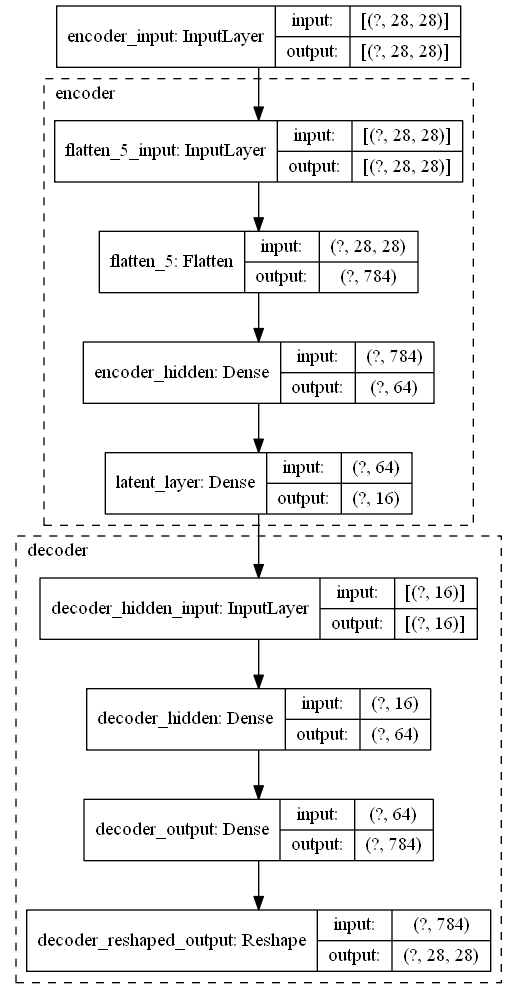

In [25]:
# Visualizing a stacked AE from pg 573
hidden_units = 64
latent_dim = 16
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(hidden_units, activation='selu', name='encoder_hidden'),
    keras.layers.Dense(latent_dim, activation='selu', name='latent_layer'),
],
name='encoder')

stacked_decoder = keras.models.Sequential([

    # Input for this is output from encoding layer
    # Typing input_shape here automatically generates the input layer to the hidden decoder_layer
    keras.layers.Dense(hidden_units, activation='selu', input_shape=[latent_dim], name='decoder_hidden'),

    # Output represents a pixel for mnist
    keras.layers.Dense(28 * 28, activation='sigmoid', name='decoder_output'),

    # Reshape the output to a 28 x 28 image
    keras.layers.Reshape([28, 28], name='decoder_reshaped_output'),
],
name='decoder')

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(lr=1.5))

# Model summary
stacked_ae.summary()

# Model plot
keras.utils.plot_model(
    stacked_ae, 
    to_file='./images/submodel_based_autoencoder.png',
    show_shapes=True,
    expand_nested=True
)

In [ ]:
## Input to autoencoder model
input_ = keras.layers.Flatten(input_shape=[28, 28], name='model_input')

## Encoder
# Encoder hidden1 then connect
encoder_hidden = keras.layers.Dense(hidden_units, activation='selu', name='encoder_hidden')
encoder_hidden = encoder_hidden(input_)

## Latent representation (densely connected output from encoder hidden) then connect
latent = keras.layers.Dense(latent_dim, activation='selu', name='latent')
latent = latent(encoder_hidden)

## Decoder
# Input to decoder?
# decoder_input

# decoder hidden connected with latent representation then connect
decoder_hidden = keras.layers.Dense(hidden_units, activatin='selu', name='decoder_hidden')

# output results
decoder_output = keras.layers.Dense(28 * 28, activation='sigmoid', name='decoder_output')
d

# Reshaped output
output = keras.layers.Reshape([28, 28], name='decoder_reshaped_output')

#

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
encoder_hidden (Dense)       (None, 64)                50240     
_________________________________________________________________
latent_layer (Dense)         (None, 16)                1040      
_________________________________________________________________
decoder_hidden (Dense)       (None, 64)                1088      
_________________________________________________________________
decoder_output (Dense)       (None, 784)               50960     
_________________________________________________________________
decoder_reshaped_output (Res (None, 28, 28)            0         
Total params: 103,328
Trainable params: 103,328
Non-trainable params: 0
________________________________________________

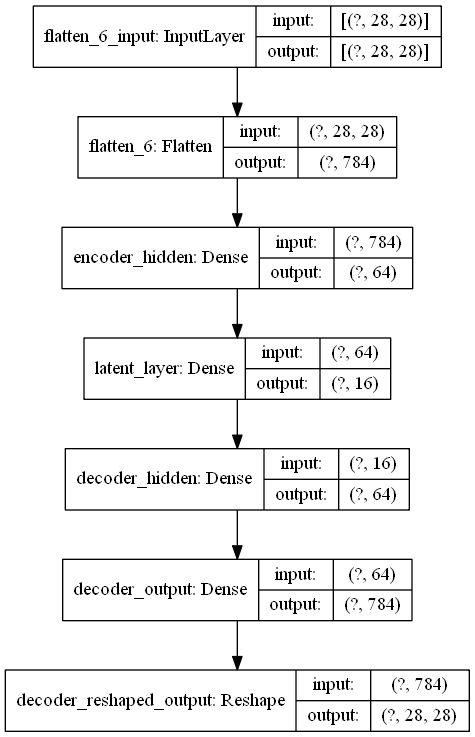

In [26]:
# Build the autoencoder as a sequential network only to see if saving/loading works then
combined_seq_autoencoder = keras.models.Sequential([
    
    # Input 
    keras.layers.Flatten(input_shape=[28,28]),

    # Encoder hidden
    keras.layers.Dense(hidden_units, activation='selu', name='encoder_hidden'),
    
    # Latent layer
    keras.layers.Dense(latent_dim, activation='selu', name='latent_layer'),

    # Decoder hidden
    keras.layers.Dense(hidden_units, activation='selu', name='decoder_hidden'),
    
    # Output represents a pixel for mnist
    keras.layers.Dense(28 * 28, activation='sigmoid', name='decoder_output'),

    # Reshape the output to a 28 x 28 image
    keras.layers.Reshape([28, 28], name='decoder_reshaped_output'),
])

# Compile the model
combined_seq_autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(lr=1.5)
)

# Summary
combined_seq_autoencoder.summary()

# Model plot
keras.utils.plot_model(
    combined_seq_autoencoder, 
    to_file='./images/combined_seq_autoencoder.png',
    show_shapes=True,
    expand_nested=True
)

In [27]:
%%time

# Train the stacked_ae
history = stacked_ae.fit(
    X_train, 
    X_train, 
    epochs=10,
    validation_data=[X_valid, X_valid],
    verbose=1
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.3442 - val_loss: 0.3165
Epoch 2/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3108 - val_loss: 0.3073
Epoch 3/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.3047 - val_loss: 0.3034
Epoch 4/10
55000/55000 [==============================] - 7s 123us/sample - loss: 0.3010 - val_loss: 0.3030
Epoch 5/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.2986 - val_loss: 0.2984
Epoch 6/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.2967 - val_loss: 0.2968
Epoch 7/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.2955 - val_loss: 0.2955
Epoch 8/10
55000/55000 [==============================] - 6s 107us/sample - loss: 0.2945 - val_loss: 0.2945
Epoch 9/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2936 - 

In [28]:
%%time

# Train the combined sequential autoencoder
history = combined_seq_autoencoder.fit(
    X_train, 
    X_train, 
    epochs=10,
    validation_data=[X_valid, X_valid],
    verbose=1
)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3444 - val_loss: 0.3161
Epoch 2/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3102 - val_loss: 0.3083
Epoch 3/10
55000/55000 [==============================] - 6s 111us/sample - loss: 0.3043 - val_loss: 0.3035
Epoch 4/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.3014 - val_loss: 0.3013
Epoch 5/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.2992 - val_loss: 0.2993
Epoch 6/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.2977 - val_loss: 0.2974
Epoch 7/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2963 - val_loss: 0.2976
Epoch 8/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2952 - val_loss: 0.2958
Epoch 9/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2942 -

Saving figure submodel_based_reconstruction_plot
Saving figure combined_seq_reconstruction_plot


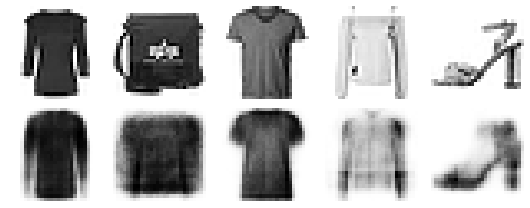

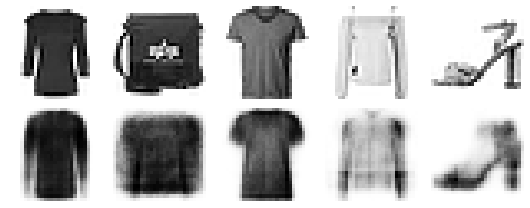

In [30]:
# Generate images based on submodel autoencoder
show_reconstructions(stacked_ae, images=X_valid)
save_fig("submodel_based_reconstruction_plot")

# Generate images based on sequential autoencoder
show_reconstructions(stacked_ae, images=X_valid)
save_fig("combined_seq_reconstruction_plot")

In [32]:
# Save the submodel autoencoder
stacked_ae.save('./saved_submodel_autoencoder')

INFO:tensorflow:Assets written to: ./saved_submodel_autoencoder\assets


In [33]:
# Save the combined sequential model
combined_seq_autoencoder.save('./saved_combined_seq_autoencoder')

INFO:tensorflow:Assets written to: ./saved_combined_seq_autoencoder\assets


In [47]:
# Saving the decoder
stacked_decoder.save('./saved_example_decoder')

INFO:tensorflow:Assets written to: ./saved_example_decoder\assets


In [49]:
# Save the encoder
stacked_encoder.save('./saved_example_encoder')

INFO:tensorflow:Assets written to: ./saved_example_encoder\assets


In [37]:
# Load the autoencoder
loaded_stacked_ae = keras.models.load_model('./saved_submodel_autoencoder')

ValueError: An empty Model cannot be used as a Layer.

In [38]:
# Load the sequential model
loaded_combined_seq_autoencoder = keras.models.load_model('./saved_combined_seq_autoencoder')

In [35]:
# Load the decoder
loaded_stacked_decoder = keras.models.load_model('./saved_example_decoder')

In [36]:
# Load the encoder
loaded_stacked_encoder = keras.models.load_model('./saved_example_encoder')